# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

Homework 2 - MSc student Amedeo Giuliani

# Autoencoder

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

torch.manual_seed(2005797) #for reproducible results
torch.cuda.manual_seed(2005797)

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dataset, val_dataset = train_test_split(train_dataset, test_size=10000, random_state=2005797)

train_dataloader = DataLoader(train_dataset, batch_size=300, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=300, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=300, shuffle=False, num_workers=0)

26422272it [00:02, 9444174.30it/s]                              


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



29696it [00:00, 744375.10it/s]           


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



4422656it [00:00, 8004347.71it/s]                              


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



6144it [00:00, 3081775.15it/s]          

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw


In [3]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=288, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=288),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

class AutoEncoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoded_space_dim = encoded_space_dim

        self.encoder = Encoder(encoded_space_dim=self.encoded_space_dim)
        self.decoder = Decoder(encoded_space_dim=self.encoded_space_dim)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # <- return a tuple of two values

In [4]:
encoded_space_dim = 5
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
params = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params, lr=1e-3, weight_decay=0)

# Check if the GPU is available and move the encoder/decoder to it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [5]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    train_loss = []
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # store batch loss
        train_loss.append(loss.detach().cpu().numpy())

    # compute global loss
    train_loss = np.mean(train_loss)
    return train_loss

### Validation function
def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    val_loss = []
    val_loss_log = []
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
num_epochs = 10
train_loss_log = []
val_loss_log = []
for epoch in tqdm(range(num_epochs)):
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)

    # create loss history
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


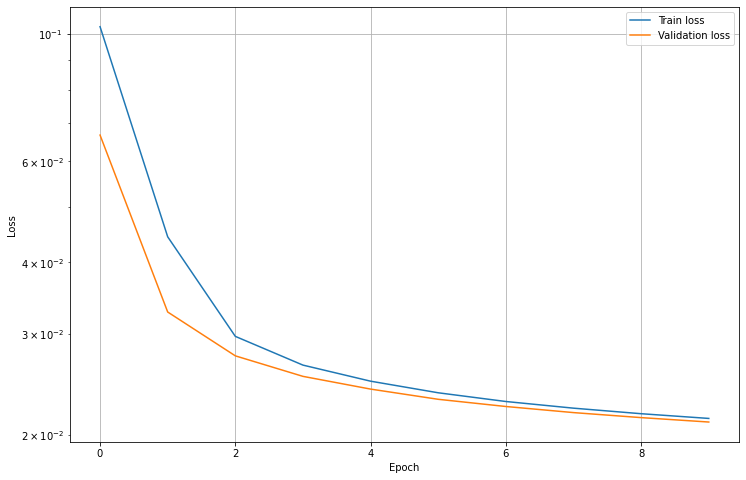

In [7]:
# Plot loss history
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('train_val_loss.png')

## Grid search

In [8]:
### Training cycle

# Define the loss function
loss_fn = torch.nn.MSELoss()

# parameter dictionary
max_epochs = [10,20]
encoded_space_dims = [2,5]
batch_sizes = [300,600]

best_max_epochs = -1
best_encoded_space_dim = -1
best_batch_size = -1
best_val_loss = np.inf

for num_epochs in max_epochs:
  for encoded_space_dim in encoded_space_dims:
    for batch_size in batch_sizes:
      print('max_epochs='+str(num_epochs)+' encoded_space_dim='+str(encoded_space_dim)+' batch_size='+str(batch_size))

      train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
      val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
      test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

      encoder = Encoder(encoded_space_dim=encoded_space_dim)
      decoder = Decoder(encoded_space_dim=encoded_space_dim)

      # Define the optimizer
      params = [
          {'params': encoder.parameters()},
          {'params': decoder.parameters()}
      ]
      optim = torch.optim.Adam(params, lr=1e-3, weight_decay=0)

      encoder.to(device)
      decoder.to(device)

      #num_epochs = 10
      train_loss_log = []
      val_loss_log = []
      for epoch in range(num_epochs):
          ### Training (use the training function)
          train_loss = train_epoch(
              encoder=encoder, 
              decoder=decoder, 
              device=device, 
              dataloader=train_dataloader, 
              loss_fn=loss_fn, 
              optimizer=optim)
          ### Validation  (use the testing function)
          val_loss = val_epoch(
              encoder=encoder, 
              decoder=decoder, 
              device=device, 
              dataloader=val_dataloader, 
              loss_fn=loss_fn)

          # create loss history
          train_loss_log.append(train_loss)
          val_loss_log.append(val_loss)

          # Save network parameters
          torch.save(encoder.state_dict(), 'encoder_params.pth')
          torch.save(decoder.state_dict(), 'decoder_params.pth')

      if val_loss_log[-1] < best_val_loss:
        best_val_loss = val_loss_log[-1]
        best_batch_size = batch_size
        best_encoded_space_dim = encoded_space_dim
        best_max_epochs = num_epochs

print('Best validation loss:',best_val_loss)
print('Best parameters:')
print('batch size = ',best_batch_size)
print('latent space = ',best_encoded_space_dim)
print('epochs = 'best_max_epochs)

max_epochs=10 encoded_space_dim=2 batch_size=300
max_epochs=10 encoded_space_dim=2 batch_size=600
max_epochs=10 encoded_space_dim=5 batch_size=300
max_epochs=10 encoded_space_dim=5 batch_size=600
max_epochs=20 encoded_space_dim=2 batch_size=300
max_epochs=20 encoded_space_dim=2 batch_size=600
max_epochs=20 encoded_space_dim=5 batch_size=300
max_epochs=20 encoded_space_dim=5 batch_size=600
Best validation loss and parameters:
tensor(0.0195) 300 5 20


100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


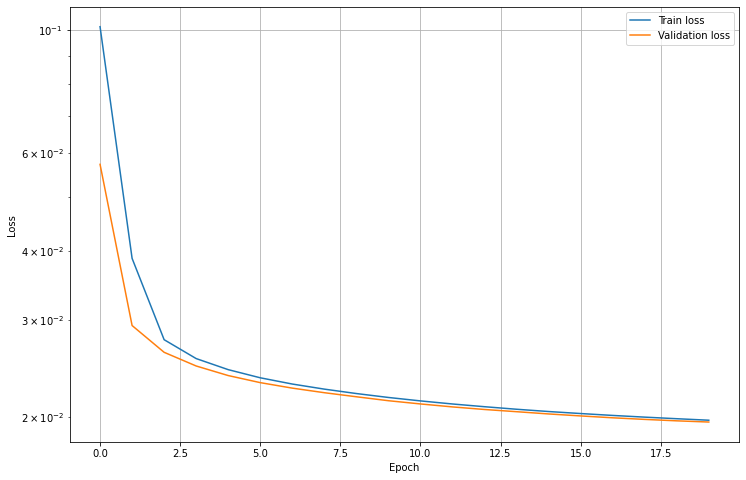

In [9]:
# Plot loss history after GS

num_epochs = best_max_epochs
train_dataloader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)

encoder = Encoder(encoded_space_dim=best_encoded_space_dim)
decoder = Decoder(encoded_space_dim=best_encoded_space_dim)

# Define the optimizer
params = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params, lr=1e-3, weight_decay=0)

encoder.to(device)
decoder.to(device)

train_loss_log = []
val_loss_log = []
for epoch in tqdm(range(num_epochs)):
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)

    # create loss history
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('train_val_loss.png')

## Testing

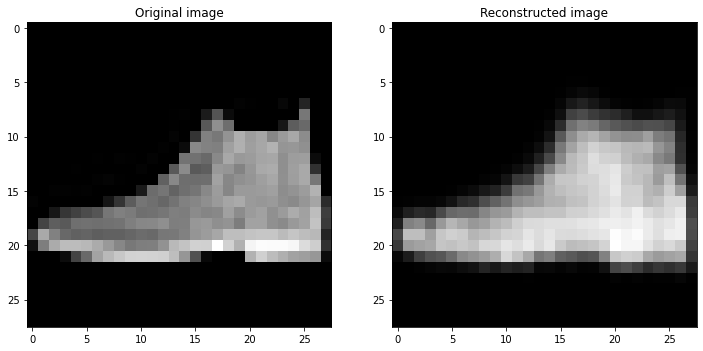

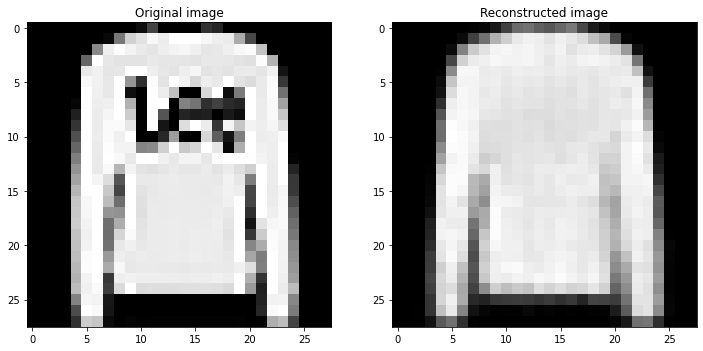

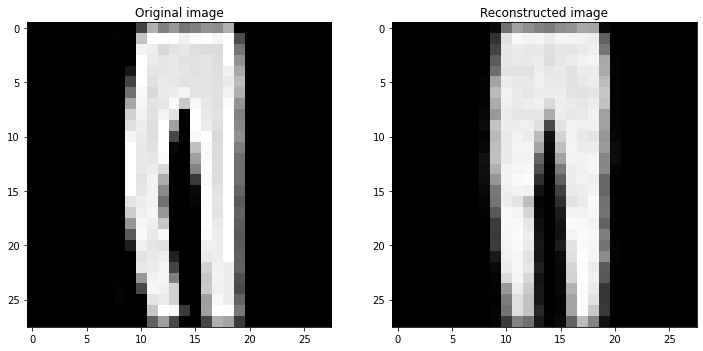

In [10]:
test_iter = iter(test_dataloader)
test_batch = test_iter.next()
for i in range(3):
  ti = test_batch[0][i]
  fig, axs = plt.subplots(1, 2, figsize=(12,6))
  axs[0].set_title('Original image')
  axs[0].imshow(ti.squeeze(), cmap='gist_gray')
  ti = ti.unsqueeze(0)
  ti = ti.to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    reconstructed = decoder(encoder(ti))
  axs[1].set_title('Reconstructed image')
  axs[1].imshow(reconstructed.cpu().squeeze(), cmap='gist_gray')

## Fine tuning

In [25]:
print('Encoder before:')
print(encoder)

for param_name, param in encoder.named_parameters():
  print(param_name)
  print('Freezing layer',param_name)
  param.requires_grad = False

encoder.encoder_lin[2] = nn.Linear(in_features=64,out_features=10,bias=True)

for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True 
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True

print('Encoder after:')
print(encoder)
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

Encoder before:
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)
encoder_cnn.0.weight
Freezing layer encoder_cnn.0.weight
encoder_cnn.0.bias
Freezing layer encoder_cnn.0.bias
encoder_cnn.2.weight
Freezing layer encoder_cnn.2.weight
encoder_cnn.2.bias
Freezing layer encoder_cnn.2.bias
encoder_cnn.4.weight
Freezing layer encoder_cnn.4.weight
encoder_cnn.4.bias
Freezing layer encoder_cnn.4.bias
encoder_lin.0.weight
Freezing layer encoder_lin.0.weight
encoder_lin.0.bias
Freezing layer en

In [26]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
optim = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder.to(device)

### Training function
def train_epoch(net, device, dataloader, loss_fn, optimizer):
    # Set train mode
    net.train()
    for image_batch, label_batch in dataloader:
        # Move tensors to the selected device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(image_batch)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Testing function
def test_epoch(net, device, dataloader, loss_fn):
    # Set evaluation mode
    net.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss

In [27]:
### Training cycle
num_epochs = 50
train_losses = []
val_losses = []
for epoch in tqdm(range(num_epochs)):
    ### Training (use the training function)
    train_epoch(
        net=encoder,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    # NOTE: understand why we are doing this!
    _, _, train_loss = test_epoch(
        net=encoder,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn)
    # Print Train loss
    train_losses.append(train_loss)

    ### Validation  (use the testing function)
    _, _, val_loss = test_epoch(
        net=encoder,
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    val_losses.append(val_loss)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


### Testing

In [28]:
### Test loss
test_outputs, test_labels, test_loss = test_epoch(
    net=encoder,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"TEST LOSS : {test_loss}")

from sklearn.metrics import accuracy_score

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

dataiter = iter(test_dataloader)
images,labels = dataiter.next()

images = images.to(device)

softmax = nn.Softmax(dim=-1)
outputs = softmax(encoder(images))
guess = outputs.max().cpu().detach().numpy()

_,pred = torch.max(outputs,1)
pred = pred.cpu()
print('Test accuracy: '+str(accuracy_score(pred,labels)*100)+'%')

TEST LOSS : 0.42213931679725647
Test accuracy: 84.77%


## PCA and t-SNE

In [15]:
import pandas as pd

### Get the encoded representation of the test samples
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,label
0,-2.564945,-3.371244,-10.214651,-6.293928,-18.559000,6.293514,-2.866978,8.344058,0.637042,10.677559,9
1,2.282225,-2.695661,10.029544,0.283263,4.556940,-11.079605,6.833615,-14.477310,-2.061113,-9.460500,2
2,1.041236,16.159082,-2.819027,2.893991,-0.568247,-11.672048,-0.246731,-46.038586,3.035948,-16.700319,1
3,1.246181,17.918268,-1.335544,6.340950,-0.833382,-17.271679,-2.296252,-33.052162,-6.044117,-11.520480,1
4,4.962333,-1.351429,3.411210,3.108206,0.881353,-4.321322,6.539035,-11.574758,-1.306858,-3.189130,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.966429,-9.011696,-11.245672,-3.886127,-18.925760,6.967171,1.018671,8.695758,-1.659967,15.525249,9
9996,2.297024,14.351667,-0.130231,6.884023,0.021886,-15.730425,-1.147085,-19.072309,-4.613068,-9.789297,1
9997,3.678572,-3.694371,-0.453008,3.422087,0.709614,-4.826445,1.822726,-1.565363,9.996613,-8.963449,8
9998,-2.340410,12.909983,-4.313421,5.381633,-5.188756,-13.946050,-2.769163,-35.153751,-2.700987,-5.372416,1


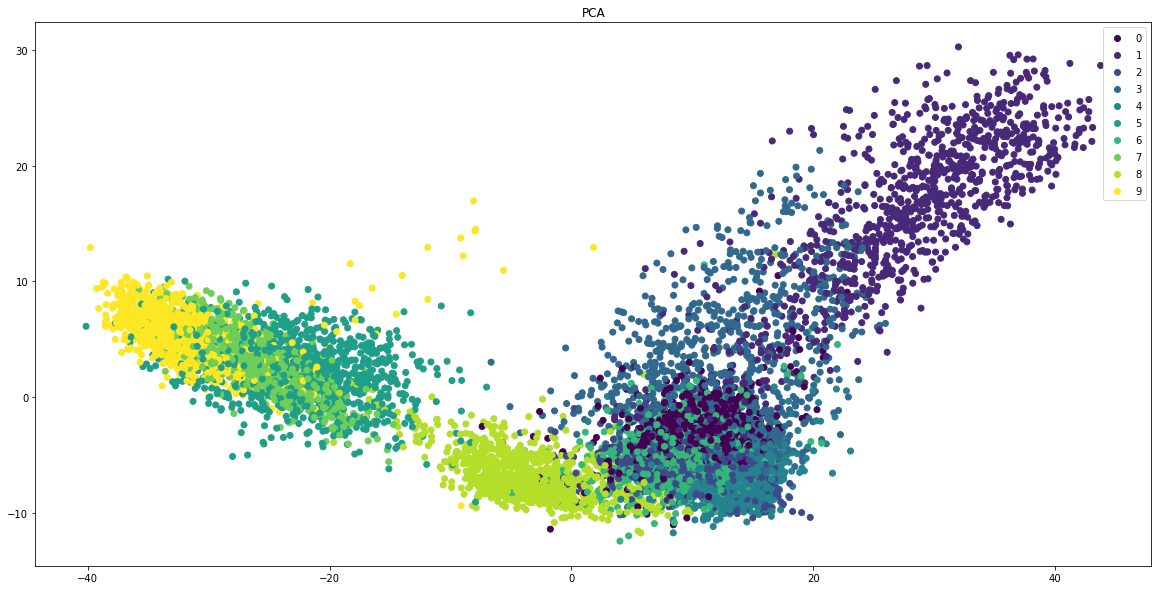

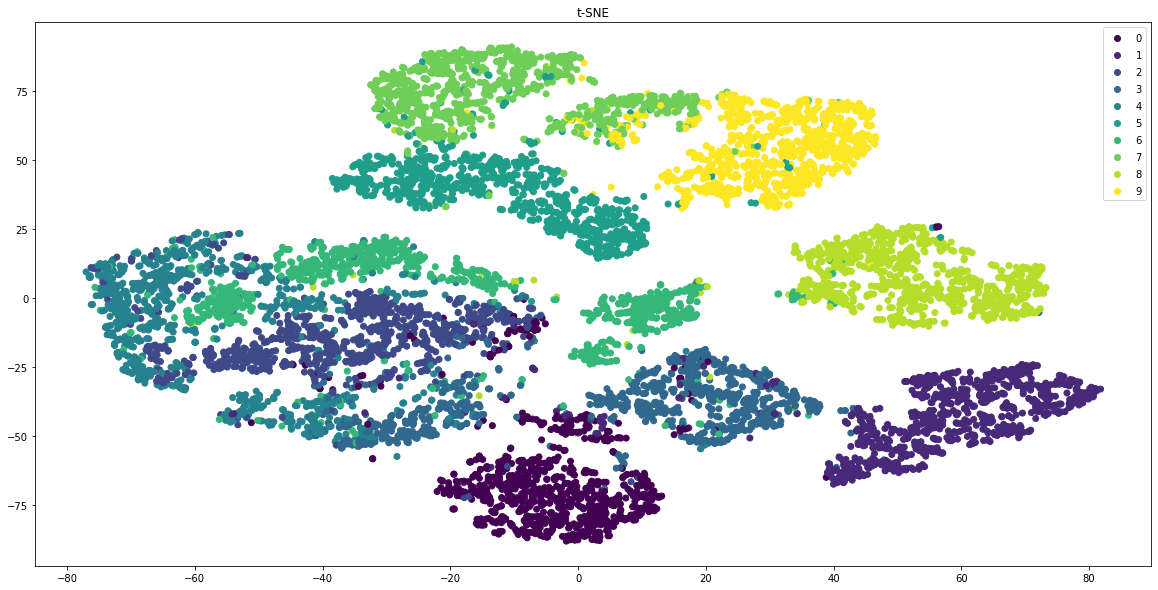

In [26]:
display(encoded_samples)

plt.figure(figsize=(20,10))
plt.title('PCA')
plot = plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())
plt.legend(*plot.legend_elements())

plt.figure(figsize=(20,10))
plt.title('t-SNE')
plot = plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())
plt.legend(*plot.legend_elements())

## Generate new samples from latent codes

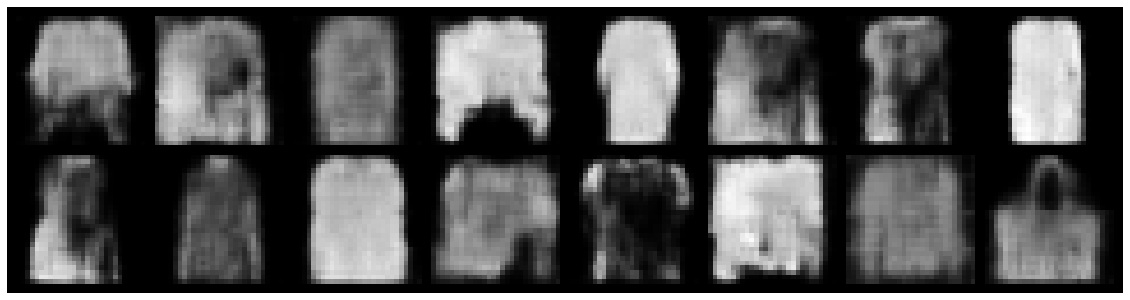

In [122]:
import torchvision.utils as vutils

z = torch.randn(16,5,device=device)*8
decoder.eval()
with torch.no_grad():
    rec = decoder(z)
    
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(rec, padding=2, normalize=True).cpu(),(1,2,0)))

# Deep Convolutional GAN

In [63]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
!tar -xf kkanji.tar

--2022-01-04 08:32:05--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar’

kkanji.tar          100%[===================>] 309.27M  12.6MB/s    in 30s     

2022-01-04 08:32:35 (10.3 MB/s) - ‘kkanji.tar’ saved [324290560/324290560]



In [29]:
from __future__ import print_function
#%matplotlib inline
from tqdm import tqdm
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

random.seed(2005797)
torch.manual_seed(2005797)
torch.cuda.manual_seed(2005797)
np.random.seed(2005797)
os.environ['PYTHONHASHSEED']=str(2005797)

In [30]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 8

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [31]:
train_dataset = torchvision.datasets.ImageFolder('data/kkanji2', transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
print(len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dataloader))

140424
1098


In [32]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

torch.Size([128, 3, 64, 64])


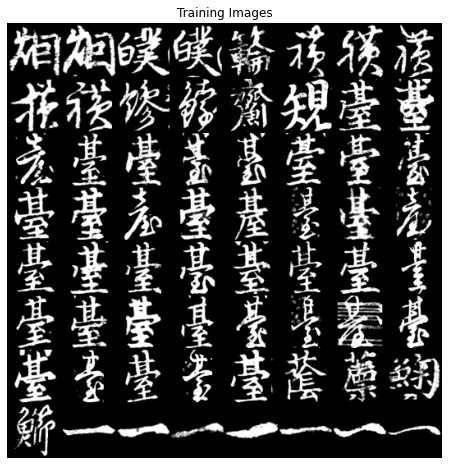

In [33]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_dataloader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [35]:
# Create the generator
netG = Generator(ngpu).to(device)
#netG = Generator(nz).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [36]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_loss_log = []
D_loss_log = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        #if i % 50 == 0:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, num_epochs, i, len(train_dataloader),
        #             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    G_loss_log.append(np.mean(G_losses))
    D_loss_log.append(np.mean(D_losses))

Starting Training Loop...


100%|██████████| 8/8 [1:23:15<00:00, 624.48s/it]


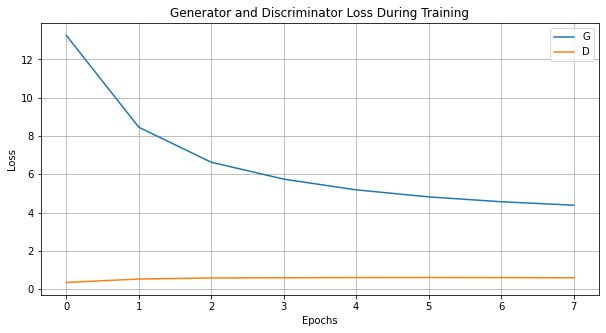

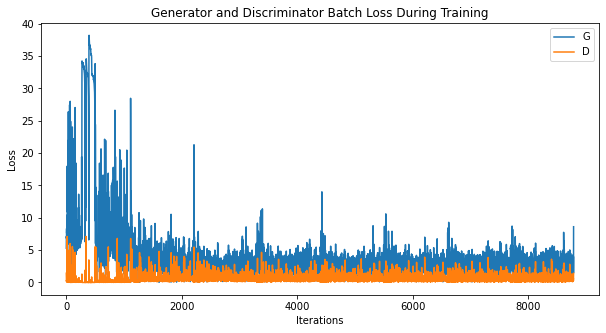

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_log,label="G")
plt.plot(D_loss_log,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Batch Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

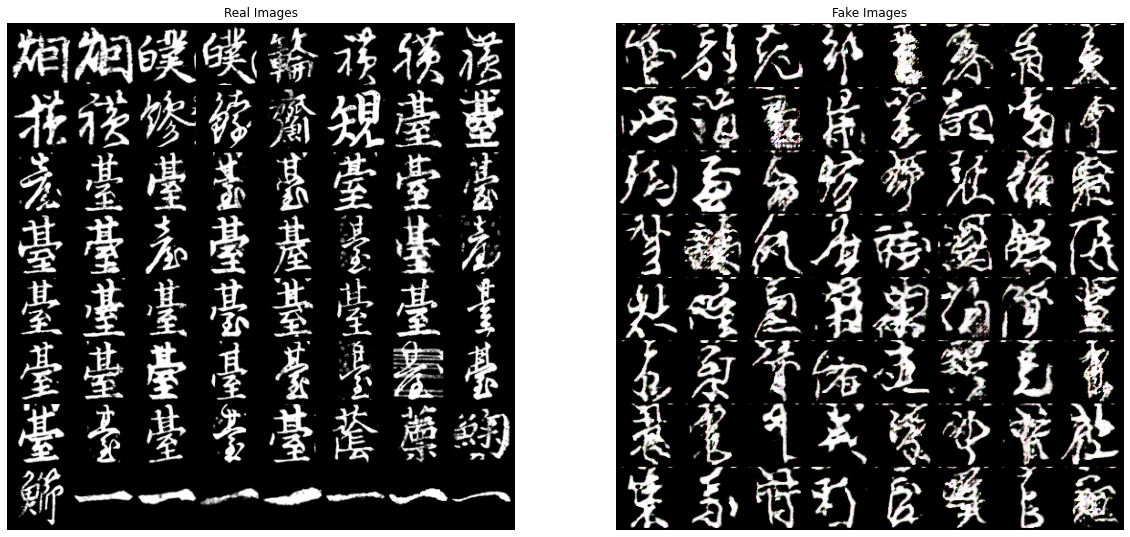

In [38]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

torch.Size([64, 3, 64, 64])


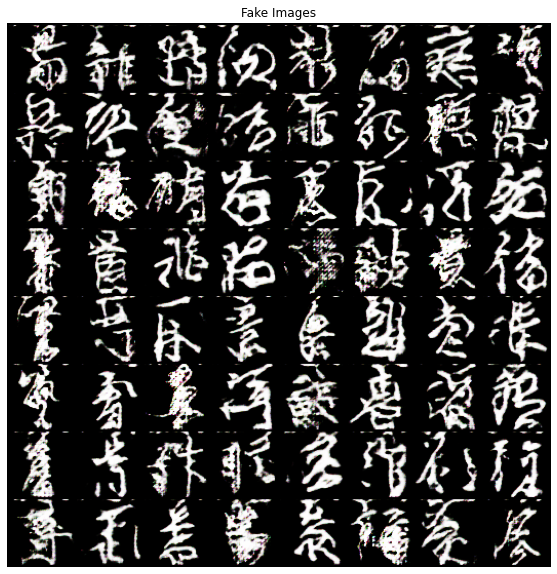

In [41]:
netG.eval()
with torch.no_grad():
    # Generate batch of latent vectors
    noise = torch.randn(image_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise).detach().cpu()

print(fake.shape)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))